# Data Science Project - part 2:  Unsupervised Learning: DBSCAN Clustering

## Objective
Apply the DBSCAN clustering algorithm on multiple datasets and evaluate
its performance using clustering metrics.

## Methodology
- Data preprocessing
- Hyperparameter selection (eps, min_samples)
- Evaluation using silhouette score
- Visualization using dimensionality reduction

## Key Takeaways
This notebook demonstrates how dataset structure affects clustering quality
and the sensitivity of DBSCAN to its parameters.


# DBSCAN Algorithm - Summary

## What is DBSCAN?  
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm. It identifies dense regions as clusters and classifies other points as "noise." The algorithm relies on two key hyperparameters:  
- **Eps (ε)** – The radius of a neighborhood around a point.  
- **MinPts** – The minimum number of points required for a point to be considered a core point.  

The algorithm classifies points into three categories:  
1. **Core Point** – Has at least MinPts points within ε.  
2. **Border Point** – Does not meet the MinPts threshold but is within ε of a core point.  
3. **Noise Point** – Does not belong to any cluster.  

## Advantages and Disadvantages  

### **Advantages:**  
- **Robust to noise** – DBSCAN effectively identifies and isolates outliers.  
- **Detects clusters of arbitrary shapes** – Unlike K-Means, it does not assume spherical clusters.  
- **Does not require the number of clusters to be predefined** – Unlike K-Means or K-Medoids.  

### **Disadvantages:**  
- **Sensitive to Eps and MinPts** – Choosing appropriate values is crucial for good clustering results.  
- **Struggles with varying densities** – It may fail to distinguish clusters with different density levels.  
- **Not suitable for high-dimensional data** – Performance degrades as dimensionality increases.  

## When to Use DBSCAN?  
- **For data with complex geometric structures** – Useful when clusters are not spherical.  
- **For noisy datasets with outliers** – DBSCAN efficiently detects and removes outliers.  
- **When the number of clusters is unknown** – Unlike K-Means, no prior assumption is needed.  

## When to Choose a Different Model?  
- **For high-dimensional datasets** – Other algorithms like K-Means or HDBSCAN may be more efficient.  
- **For datasets with clusters of varying densities** – Hierarchical clustering may be a better alternative.
- **For small datasets with minimal noise** – K-Means might be a simpler and faster choice.  


## Imports and help functions

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from itertools import product
from tabulate import tabulate

In [5]:
# Loading datasets (replace 'dataset1.csv' and 'dataset2.csv' with your file names)
data1 = pd.read_csv('Q2_dataset_1.csv')
data1.title = 'Q2_dataset_1'
data2 = pd.read_csv('Q2_dataset_2.csv')
data2.title = 'Q2_dataset_2'

In [6]:
# Function to display DataFrame statistics with a title
def display_stats(df, title):
    print(f"\nStatistics for {title}:")
    description = df.describe(include='all')
    # Only drop columns if they exist in the DataFrame
    if all(col in description.columns for col in ['min', '25%', '50%', '75%', 'max']):
        description = description.drop(['min', '25%', '50%', '75%', 'max'], axis=1)  # Specify axis=1 for columns
    display(description)

# Get basic statistics for each DataFrame and display them
display_stats(data1, data1.title)
display_stats(data2, data2.title)


Statistics for Q2_dataset_1:


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-2.890346,-0.628228,3.456328,-1.031542,4.968286,-0.666511,-3.141649,-3.805102,-4.183958,3.006700
std,6.744552,5.288661,4.416256,3.562375,5.118662,7.494507,10.123299,4.595349,6.184421,7.949377
min,-31.469044,-28.709151,-15.996312,-14.769475,-20.781306,-34.959542,-50.452660,-22.007819,-32.309091,-36.889554
25%,-6.890789,-5.345756,0.172970,-3.587177,2.471832,-5.127722,-8.850603,-6.546544,-7.944621,1.770332
50%,-4.963217,0.770253,4.053332,-0.591742,4.021040,1.431868,-6.792071,-4.819257,-5.725563,4.616522
75%,2.948247,2.282670,5.585152,0.846447,9.142309,3.375854,4.281358,-0.143518,-0.412363,6.616847
max,42.216974,24.677629,26.061612,27.905460,23.725748,38.128172,46.191238,22.533860,28.104035,43.477061



Statistics for Q2_dataset_2:


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-1.500580,1.801323,-0.846497,-0.248442,-5.901316,2.896435,-2.224918,0.273869,1.105316,-0.792361
std,6.072775,5.701843,4.243505,5.451496,1.873906,7.264336,3.074653,4.693956,2.835381,5.368675
min,-13.509180,-10.758482,-9.177302,-11.484704,-10.518682,-11.769960,-7.850089,-9.373130,-4.203416,-11.129373
25%,-6.773947,-3.849643,-4.599538,-5.347348,-7.461030,-5.399238,-4.946087,-4.089362,-0.860137,-5.602632
50%,-1.802404,4.459628,-0.244435,1.237823,-5.879753,5.526059,-2.686103,0.631885,0.067129,-1.557389
75%,5.078180,5.561500,2.891957,3.984338,-4.396349,8.608997,0.580761,4.236382,3.396355,3.798207
max,10.116913,13.034820,7.456653,10.231795,-1.632893,16.241557,5.123131,9.355502,8.681192,9.702642


#### Normaliez
Initialize a StandardScaler to normalize the data before clustering.
ensure all features have the same scale, preventing features with larger ranges from dominating clustering, improving DBSCAN performance.

In [8]:
scaler = StandardScaler()
data1 = scaler.fit_transform(data1)
data2 = scaler.fit_transform(data2)

## 2. Choosing the hyperparameters DBSCAN

In [10]:
def plot_silhouette_epsilon(eps_values, silhouette_scores):
    plt.figure(figsize=(10, 6))
    
    # Plot with softer colors and styles
    plt.plot(eps_values, silhouette_scores, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8, markerfacecolor='white', markeredgewidth=2)
    
    # Labels and title with softer fonts
    plt.xlabel("Epsilon (ε)", fontsize=14, fontweight='light')
    plt.ylabel("Silhouette Score", fontsize=14, fontweight='light')
    plt.title("Silhouette Score vs Epsilon", fontsize=16, fontweight='light')
    
    # Grid with softer lines
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Ticks with softer fonts
    plt.xticks(fontsize=12, fontweight='light')
    plt.yticks(fontsize=12, fontweight='light')
    
    # Light background color
    plt.gca().set_facecolor('#f9f9f9')
    
    plt.show()

In [11]:
def find_optimal_dbscan(X, eps_range, minPts_range):
    """
    Finds the optimal ε (Eps) and MinPts values for DBSCAN using the Silhouette Score.

    Parameters:
    X (array-like): The dataset.
    eps_range (list): List of possible ε (neighborhood radius) values.
    minPts_range (list): List of possible MinPts (minimum core point density) values.

    Process:
    - Runs DBSCAN for each (ε, MinPts) pair.
    - Computes the Silhouette Score for valid clusters.
    - Tracks the best **ε**, **MinPts**, and score.  
    - Plots silhouette scores for different **ε** values.

    Returns:
    tuple: (best_eps, best_minPts, best_score, n_clusters, labels)
        - best_eps (float): Optimal ε value.
        - best_minPts (int): Optimal MinPts value.
        - best_score (float): Highest Silhouette Score.
        - n_clusters (int): Number of detected clusters.
        - labels (array): Cluster labels for the dataset.

    Example:
    best_eps, best_minPts, best_score, n_clusters, labels = find_optimal_dbscan(X, eps_range, minPts_range)
    """
    best_score = -1
    best_eps = None
    best_minPts = None
    labels = None
    silhouette_scores = []
    eps_values = []
    
    for eps in eps_range:
        for minPts in minPts_range: 
            db = DBSCAN(eps=eps, min_samples=minPts).fit(X)
            labels = db.labels_
            if len(set(labels)) > 1:  #make sure there is more then one cluster
                score = silhouette_score(X, labels)
                eps_values.append(eps)
                silhouette_scores.append(score)
                            
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_minPts = minPts
                    labels = db.labels_
                    # Number of clusters in labels, ignoring noise if present.
                    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    plot_silhouette_epsilon(eps_values,silhouette_scores)                
    return best_eps, best_minPts, best_score ,n_clusters , labels

In [12]:
# range for params search
eps_range = np.arange(0.1, 2.0, 0.1)
min_samples_range = range(3, 20, 2)

#### Choosing Best Parameters for Dataset 1
evaluate **Dataset 1** to find the optimal **ε (Eps)** and **MinPts** for DBSCAN.  
We define a search space for these hyperparameters and use the `find_optimal_dbscan` function  
to determine the best values based on the **Silhouette Score**.

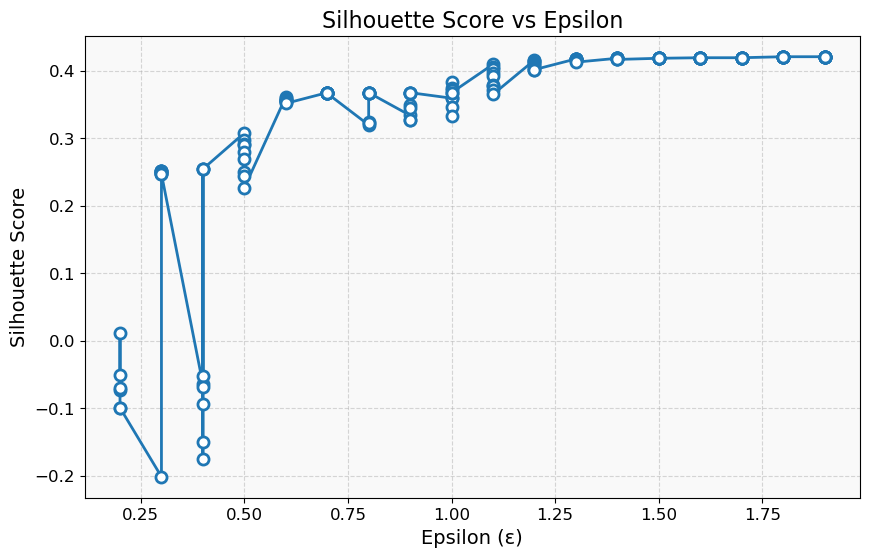

Optimal parameters for Dataset 1: eps=1.8000000000000003, minPts=3, silhouette score=0.4206280453751602, number of clusters = 3


In [21]:
best_eps_1, best_minPts_1, silhouette_score_1 ,num_clusters_1 , labels_1= find_optimal_dbscan(data1, eps_range, min_samples_range)
print(f"Optimal parameters for Dataset 1: eps={best_eps_1}, minPts={best_minPts_1}, silhouette score={silhouette_score_1}, number of clusters = {num_clusters_1}")

#### Choosing Best Parameters for Dataset 2
evaluate **Dataset 2** to find the optimal **ε (Eps)** and **MinPts** for DBSCAN.  
We define a search space for these hyperparameters and use the `find_optimal_dbscan` function  
to determine the best values based on the **Silhouette Score**.

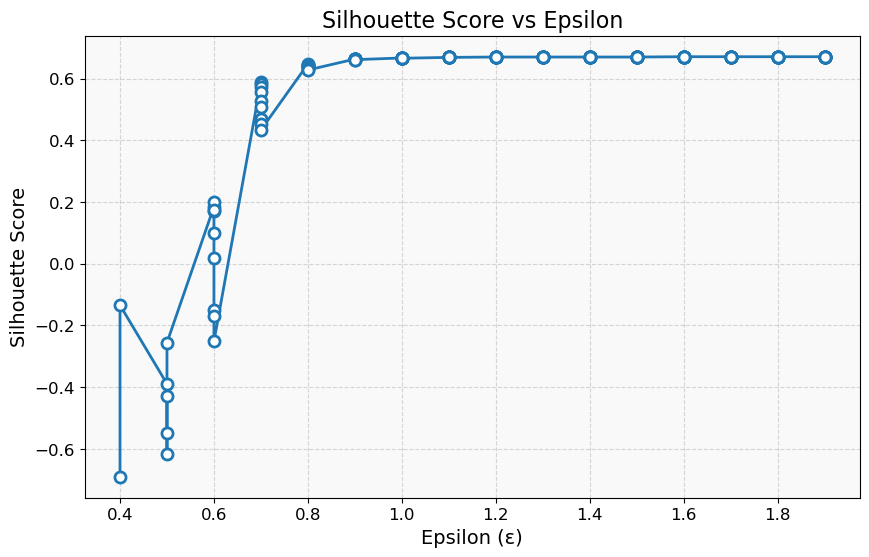

Optimal parameters for Dataset 2: eps=1.6, minPts=3, silhouette score=0.6711572700697676, number of clusters = 4


In [23]:
best_eps_2, best_minPts_2, silhouette_score_2 ,num_clusters_2 , labels_2 = find_optimal_dbscan(data2, eps_range, min_samples_range)
print(f"Optimal parameters for Dataset 2: eps={best_eps_2}, minPts={best_minPts_2}, silhouette score={silhouette_score_2}, number of clusters = {num_clusters_2}")

## 3. metrics Analysis
### Explanation for Choosing Cluster Evaluation Metrics  

When evaluating clustering models, it is essential to use multiple metrics to gain a comprehensive understanding of their performance. I have chosen three key metrics: **Silhouette Index**, **Davies-Bouldin Index**, and **Calinski-Harabasz Index**. 
- The **Silhouette Index** measures how well an object fits within its assigned cluster compared to others, balancing cohesion and separation.
- The **Davies-Bouldin Index** assesses the compactness of clusters and their separation, where a lower value indicates better clustering.
- The **Calinski-Harabasz Index** evaluates the variance ratio between and within clusters, with higher values signifying well-defined clusters.  

Each of these metrics provides a unique perspective on clustering quality. The **Silhouette Index** offers insight into overall clustering structure, the **Davies-Bouldin Index** helps balance compactness and separation, and the **Calinski-Harabasz Index** objectively measures variance-based clustering performance. By combining these metrics, I ensure that my clustering algorithm is not only producing well-separated clusters but also ensuring that the clusters are compact and distinct.

In [25]:
#Compute Metrics
#Davies-Bouldin Index
db_index_1 = davies_bouldin_score(data1, labels_1)
db_index_2 = davies_bouldin_score(data2, labels_2)

# Calinski-Harabasz Index
ch_score_1 = calinski_harabasz_score(data1, labels_1)
ch_score_2 = calinski_harabasz_score(data2, labels_2)

In [26]:
#print table sammery
optimal_params = pd.DataFrame({
    "Dataset": ["Q2_dataset_1", "Q2_dataset_2"],
    "Optimal ε": [best_eps_1, best_eps_2],
    "Optimal MinPts": [best_minPts_1, best_minPts_2],
    "Number of Clusters": [num_clusters_1, num_clusters_2],
    "Silhouette Score": [silhouette_score_1, silhouette_score_2],
    "Davies-Bouldin Index": [db_index_1, db_index_2],
    "Calinski-Harabasz Index": [ch_score_1,ch_score_2]
})

# Print the table in a more aesthetic format
print(tabulate(optimal_params, headers='keys', tablefmt='pretty'))

+---+--------------+--------------------+----------------+--------------------+--------------------+----------------------+-------------------------+
|   |   Dataset    |     Optimal ε      | Optimal MinPts | Number of Clusters |  Silhouette Score  | Davies-Bouldin Index | Calinski-Harabasz Index |
+---+--------------+--------------------+----------------+--------------------+--------------------+----------------------+-------------------------+
| 0 | Q2_dataset_1 | 1.8000000000000003 |       3        |         3          | 0.4206280453751602 |  3.074520519569182   |   113.29440398181423    |
| 1 | Q2_dataset_2 |        1.6         |       3        |         4          | 0.6711572700697676 |  1.6777583745009494  |    1511.129373702701    |
+---+--------------+--------------------+----------------+--------------------+--------------------+----------------------+-------------------------+


The table shows that **Dataset 1** has **3 clusters**, whereas **Dataset 2** has **4 clusters**. This indicates that the DBSCAN algorithm identified a different number of natural groupings in each dataset based on the given parameters.


## 4. Visualization
### Clustering Visualization with PCA and t-SNE

Since our dataset has a high dimensionality, we need to reduce it to **2D** for visualization purposes.  
To achieve this, we use **Principal Component Analysis (PCA)** and **t-Distributed Stochastic Neighbor Embedding (t-SNE)**.

#### Why PCA?
PCA is a **linear dimensionality reduction** technique that captures the **maximum variance** in the data.  
It helps in understanding the **overall cluster structure** while preserving global relationships between points.

#### Why t-SNE?
t-SNE is a **non-linear** dimensionality reduction method that is particularly useful for **preserving local structure**  
in high-dimensional data. It helps in identifying dense regions and patterns in cluster assignments.

In the following visualization:
- **PCA** provides a broad overview of how clusters are spread in a **linear transformation**.
- **t-SNE** helps in capturing **non-linear relationships**, often revealing finer details in clustering structures.

Both techniques allow us to **interpret DBSCAN results** in a meaningful 2D space

In [29]:
def pca_tsne_for_cluster(data, dataset_name, labels):
    # PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    print('*********************************************************** PCA ***********************************************************')
    
    # Scatter plot for PCA
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette="Set2", legend='full', s=100, edgecolor='w', linewidth=0.5)
    plt.title(f"DBScan Clustering ({dataset_name})", fontsize=16, fontweight='light')
    plt.xlabel("PCA Component 1", fontsize=14, fontweight='light')
    plt.ylabel("PCA Component 2", fontsize=14, fontweight='light')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=12, fontweight='light')
    plt.yticks(fontsize=12, fontweight='light')
    plt.gca().set_facecolor('#f9f9f9')
    plt.show()
    
    # t-SNE visualization
    print('*********************************************************** t-SNE ***********************************************************')
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_data = tsne.fit_transform(data)
    
    # Scatter plot for t-SNE
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=labels, palette="Set2", legend='full', s=100, edgecolor='w', linewidth=0.5)
    plt.title(f"t-SNE Visualization ({dataset_name})", fontsize=16, fontweight='light')
    plt.xlabel("t-SNE Component 1", fontsize=14, fontweight='light')
    plt.ylabel("t-SNE Component 2", fontsize=14, fontweight='light')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=12, fontweight='light')
    plt.yticks(fontsize=12, fontweight='light')
    plt.gca().set_facecolor('#f9f9f9')
    plt.show()

**Q2_dataset_1 Visualization**

*********************************************************** PCA ***********************************************************


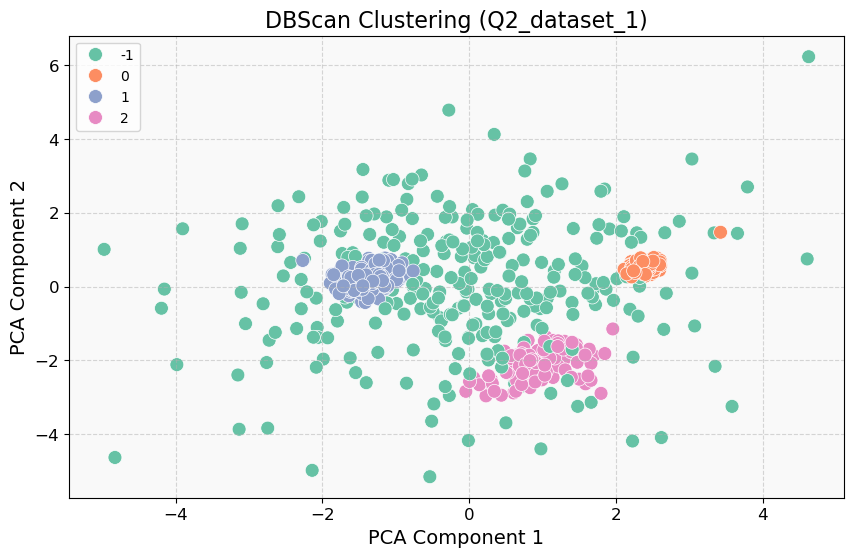

*********************************************************** t-SNE ***********************************************************


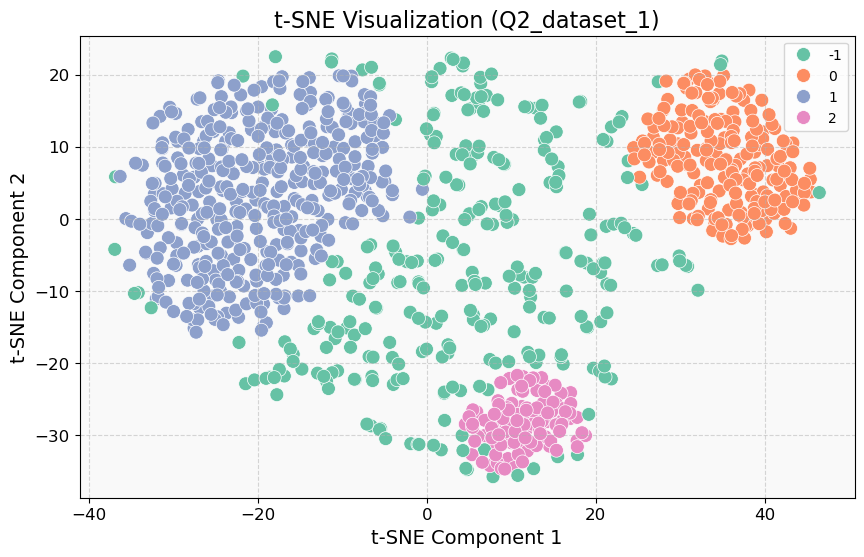

In [31]:
pca_tsne_for_cluster(data1,'Q2_dataset_1', labels_1)

**Q2_dataset_1 Visualization**

*********************************************************** PCA ***********************************************************


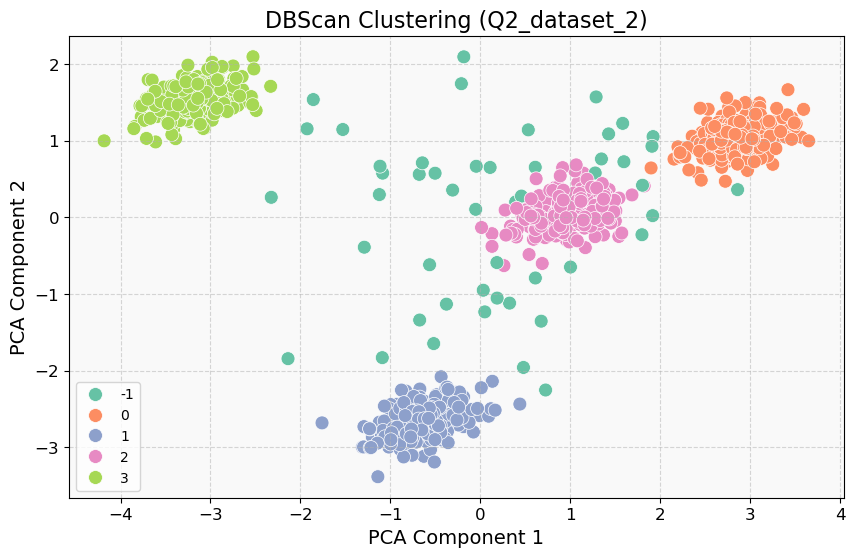

*********************************************************** t-SNE ***********************************************************


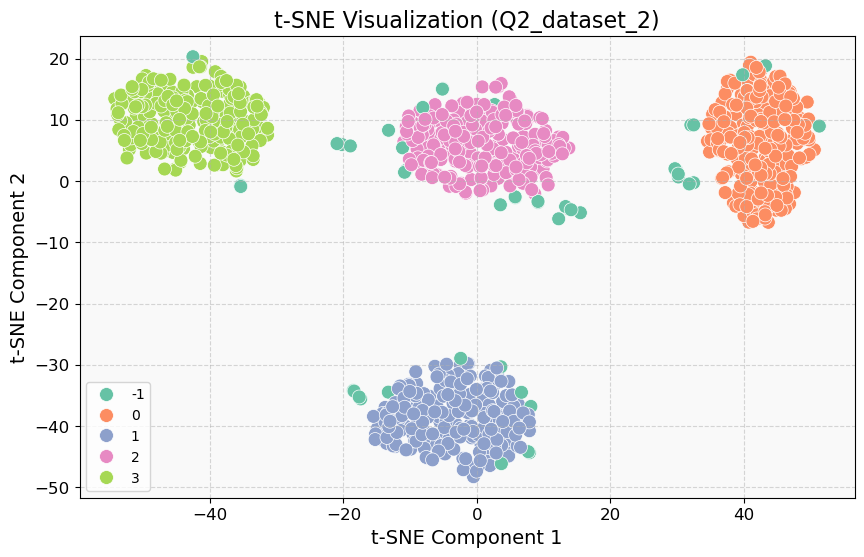

In [33]:
pca_tsne_for_cluster(data2,'Q2_dataset_2', labels_2)

## 5. Conclusions

### Dataset 1 (Q2_dataset_1):
- **Visual Inspection**: The plot of **Dataset 1** shows a more scattered structure with many points not assigned to any cluster. This suggests the presence of noise or sparse regions in the data.
- **Metrics**: The **Silhouette Score** for this dataset is relatively low (**0.42**), indicating that the clustering may not be well-defined. The **Davies-Bouldin Index** (**3.07**) is relatively high, further suggesting that the clusters are not well-separated, while the **Calinski-Harabasz Index** is moderate (**113.29**).
- **Conclusion**: The visual results align with the metrics, indicating that **Dataset 1** has some noisy data points or outliers, leading to a lower-quality clustering.

### Dataset 2 (Q2_dataset_2):
- **Visual Inspection**: The **Dataset 2** plot shows more compact and isolated clusters, with fewer points that do not belong to any cluster. This indicates clearer separations between clusters.
- **Metrics**: **Dataset 2** achieves a higher **Silhouette Score** (**0.67**), indicating better-defined clusters. The **Davies-Bouldin Index** (**1.68**) is lower, showing improved cluster separation. The **Calinski-Harabasz Index** is also much higher (**1511.13**), suggesting well-defined and separate clusters.
- **Conclusion**: The visual results support the positive metrics, indicating that **Dataset 2** is well-clustered and the DBSCAN algorithm performs better on it.

### Summary:
- The visualizations and metrics align, with **Dataset 2** showing clearer clustering and higher quality, whereas **Dataset 1** presents more scattered and less distinct clusters, with several outliers.
